### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*

In [8]:
# Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip3 install -U albumentations>=0.3.0 --user 
# !pip3 install -U --pre segmentation-models --user

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
import keras
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
keras.backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


# Utility functions 

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Segmentation model training

In [3]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [4]:
BACKBONE = 'resnet18'
CLASSES = ['current']

preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
# define network parameters
n_classes = len(CLASSES) if len(CLASSES) == 1 else len(CLASSES)+1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [7]:
# define optomizer
optim = 'Adam'

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (background: 0.5; current: 2.; neighbour: 2.; )
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1.0])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [29]:
# load best weights
model.load_weights('test_unet-resnet18-berkeley-drivable-192x320.h5')

# Test on video stream (NVIDIA Jetson Nano)

In [31]:
preprocess_input = sm.get_preprocessing(BACKBONE)
def image_preprocessing(image, size=(192, 320)):
    # convert color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # apply preprocessing
    image = cv2.resize(image, (size[1], size[0]), cv2.INTER_LINEAR)
    image = preprocess_input(image)
    img_processed = np.expand_dims(image, axis=0)
    return img_processed

In [85]:
def visual_seg_result(image, seg_mask, size):
    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros(size).astype(np.uint8)
    lane_drawn = np.dstack((blanks, seg_mask[0], blanks))

    # # Re-size to match the original image
    lane_image = cv2.resize(lane_drawn, (image.shape[1], image.shape[0]))

    # Merge the lane drawing onto the original image
    result = 0.7* (frame_raw/255.) + 0.3 * lane_image
    return result

In [92]:
from tqdm import tqdm

vs = cv2.VideoCapture('/home/tegraboy/Desktop/moscow_streets_short.mp4')
SIZE = (192, 320)

FPS = []
# while(1):
# for i in tqdm( range(100) ):
for i in range(100):
    # get raw frames from video stream
    ret, frame_raw = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    frame = image_preprocessing(frame_raw, SIZE)
    # predict segmentation mask from the frame
    start = time.time()
    pr_mask = model.predict(frame)
    dt = time.time() - start
    FPS.append(1./dt)
#     print("[INFO] single frame took {:.4f} seconds".format(dt))
    segmented_result = visual_seg_result(frame_raw, pr_mask, SIZE)

#     visualize(
#         image=denormalize(frame.squeeze()),
#         pr_mask=pr_mask[..., 0].squeeze(),
#         result=segmented_result,
#     )

print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))

[INFO] Mean FPS 5.0634 Hz


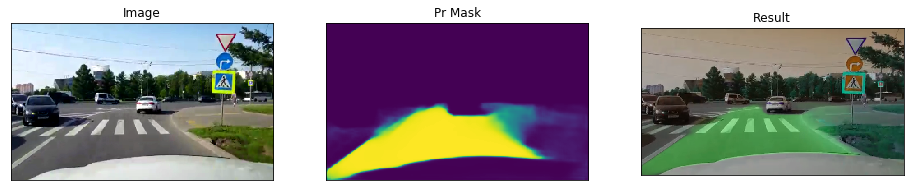

In [93]:
visualize(
    image=denormalize(frame.squeeze()),
    pr_mask=pr_mask[..., 0].squeeze(),
    result=segmented_result,
)